In [267]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




         Status Application Creation Date Approved / Refused Date  \
15192   Refused                2008-04-28              30/04/2010   
9636    Expired                2009-01-06              26/08/2009   
10589  Recorded                2009-01-10              16/10/2009   
11781  Recorded                2009-01-10              05/10/2009   
2043   Recorded                2009-01-10              09/10/2009   
...         ...                       ...                     ...   
10747  Recorded                2024-12-02              22/02/2024   
8195   Recorded                2024-12-03              16/04/2024   
16325  Recorded                2024-12-03              04/04/2024   
544    Recorded                2024-12-03              21/03/2024   
6287   Recorded                2024-12-04              16/04/2024   

      Recorded / Rejected Date Water Share ID Water System Source Reliability  \
15192               30/04/2010      WEE****03            Goulburn        High   
9636     

# Water Temperature

In [273]:
import pandas as pd
from sklearn.impute import SimpleImputer

def process_and_combine_data(file_path, merge_data=None, merge_on=('Create_date_ordinal', 'Time_ordinal'), row_thresh_multiplier=0.5):
    # Load the data
    tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')
    print("Array size:", tempData.shape)
    # Drop rows where more than half the columns have missing values
    row_thresh = len(tempData.columns) * row_thresh_multiplier
    tempData = tempData.dropna(axis=0, thresh=row_thresh)
    print("Array size:", tempData.shape)
    # Drop any columns with missing values
    tempData = tempData.dropna(axis=1, how='any')
    print("Array size:", tempData.shape)

    # Group data by 'Time', calculate the mean, and reset the index
    daily_tempData = tempData.groupby(tempData.index).mean().reset_index()
    daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())

    # If merge data is provided, merge it on the specified columns
    if merge_data is not None and merge_on:
        combined_data = pd.merge(merge_data, daily_tempData, left_on=merge_on[0], right_on=merge_on[1], how='inner')
        # Export the combined data to a CSV file
        combined_data.to_csv('combined_data.csv', index=False)
        return combined_data

    return daily_tempData

# Example usage:
Water_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv'
combined_data = process_and_combine_data(Water_temp_file_path, merge_data=zone_data_1A_top_sorted)

# Export the combined data to a CSV file
combined_data.to_csv('combined_data.csv', index=False)

Array size: (10227, 402)
Array size: (4281, 402)
Array size: (4281, 7)


In [269]:
# Load the data
file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv'
tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')

#print(tempData.isnull().sum())
# Drop columns with any missing values
row_thresh = len(tempData.columns) * 0.5  # Example threshold
tempData = tempData.dropna(axis=0, thresh=row_thresh)
print("Array size:", tempData.shape)
tempData = tempData.dropna(axis=1, how='any')
print("Array size:", tempData.shape)

# Group data by 'Time', aggregate, and convert 'Time' to ordinal
daily_tempData = tempData.groupby(tempData.index).mean().reset_index()
daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())



from sklearn.impute import SimpleImputer

# Impute missing values with the median of each column
#imputer = SimpleImputer(strategy='median')
#data_imputed = pd.DataFrame(imputer.fit_transform(tempData), columns=tempData.columns, index=tempData.index)

#print(data_imputed)

# Group imputed data by 'Time', aggregate, and convert 'Time' to ordinal
#daily_tempData = data_imputed.groupby(data_imputed.index).mean().reset_index()
#daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())

# Merge the DataFrames on the ordinal date column
combined_data = pd.merge(zone_data_1A_top_sorted, daily_tempData, left_on='Create_date_ordinal', right_on='Time_ordinal', how='inner')






Array size: (4281, 402)
Array size: (4281, 7)


# Trade off between spacial and temporal patterns

Temporal Trends: If the focus is on understanding how patterns evolve over time or capturing seasonal variations and long-term trends, having a longer time period with data from fewer stations might be more beneficial.
Spatial Patterns: If the goal is to compare spatial variations or the behavior across different locations, then analyzing more stations over a shorter period might provide more insights into spatial differences.

In [270]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf.head())


['Volume Traded (ML)', 'Price Per ML ($)', '226227', '235211', '409002', '409014', '409023', '409036', '409061']
Explained Variance Ratio: [0.6724312  0.14038459]
   principal component 1  principal component 2 Create_date
0               4.109446               1.127457  2010-01-02
1               4.221482               1.548171  2010-01-09
2               4.153734               2.201592  2010-01-09
3               4.250748               1.064722  2010-01-09
4               4.242609               1.160101  2010-01-09


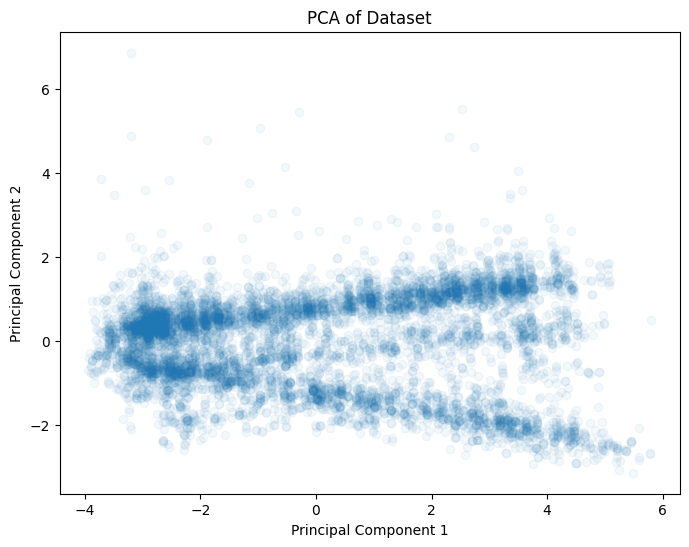

Explained Variance Ratio: [0.6724312  0.14038459]
   principal component 1  principal component 2 Create_date
0               4.109446               1.127457  2010-01-02
1               4.221482               1.548171  2010-01-09
2               4.153734               2.201592  2010-01-09
3               4.250748               1.064722  2010-01-09
4               4.242609               1.160101  2010-01-09


In [271]:
# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf.head())